# Infer building instances with a Mask-RCNN model

In [1]:
import json
import os
import numpy as np
from PIL import Image

from mrcnn import model as modellib
from mrcnn.config import Config
from mrcnn import visualize

Using TensorFlow backend.


In [2]:
from tanzania_challenge import buildings

/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/tanzania_challenge-0.1-py3.6.egg/tanzania_challenge/buildings.py:99: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/home/rde/.virtualenvs/tanz/lib/python3.6/site-packages/tanzania_challenge-0.1-py3.6.egg/tanzania_challenge/buildings.py:99: SyntaxWarning: assertion is always true, perhaps remove parentheses?


## Dataset configuration setting

In [11]:
class BuildingConfig(Config):
    NAME = "building"
    NUM_CLASSES = 1 + 3
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [12]:
config = BuildingConfig()

## Model loading

In [28]:
ls ../data/open_ai_tanzania/output/instance_segmentation/checkpoints/

buildings20181017T1652/  buildings20181109T0951/  buildings20181203T1823/
buildings20181018T1542/  buildings20181109T1412/  buildings20181203T1827/
buildings20181019T1148/  buildings20181109T1454/  buildings20181203T1828/
buildings20181108T1743/  buildings20181109T1807/  buildings20181203T1832/
buildings20181108T1800/  buildings20181203T1755/  buildings20181203T1835/
buildings20181108T1804/  buildings20181203T1800/  buildings20181203T1836/
buildings20181109T0941/  buildings20181203T1821/  buildings20181203T1844/


In [29]:
model_dir = os.path.join("..", "data", "open_ai_tanzania", "output", "instance_segmentation", "checkpoints")
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)

In [30]:
weights_path = model.find_last() ; print(weights_path)
model.load_weights(weights_path, by_name=True)

FileNotFoundError: [Errno 2] Could not find weight files in ../data/open_ai_tanzania/output/instance_segmentation/checkpoints/buildings20181203T1844

## Dataset declaration

In [7]:
test_bd = buildings.BuildingDataset()
test_bd.load_buildings(os.path.join("..", "data", "open_ai_tanzania", "preprocessed"),
                       subset="testing", img_size=config.IMAGE_MIN_DIM)
test_bd.prepare()

FileNotFoundError: [Errno 2] No such file or directory: '../data/open_ai_tanzania/preprocessed/384/testing/images'

In [8]:
nb_images = len(test_bd.image_info)

In [9]:
test_bd.num_images

62220

In [11]:
import time

for image_id in test_bd.image_ids[:1]:
    a = time.time()
    image = test_bd.load_image(image_id)
    print(np.expand_dims(image, 0).shape)
    prediction = model.detect(np.expand_dims(image, 0))
    print(prediction[0]["class_ids"])
    b = time.time()
    print(b-a)

(1, 221, 267, 3)
[1 1 1 1 1]
6.70073127746582


## Image inference

In [12]:
image_path = os.path.join("..", "data", "open_ai_tanzania", "preprocessed", "384", "testing", "images")

### Named image

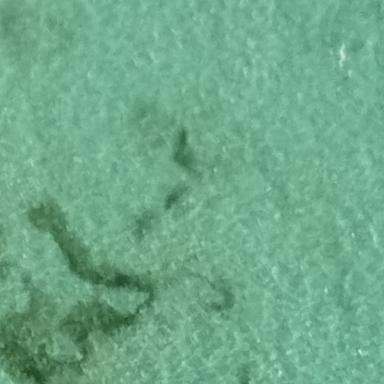

In [17]:
filename = "5ae36dd70b093000130afdbb_384_384_26112_42624.tif"
im = Image.open(os.path.join(image_path, filename)) ; im

### Random image

5ae38a540b093000130aff24_384_384_384_32640.tif


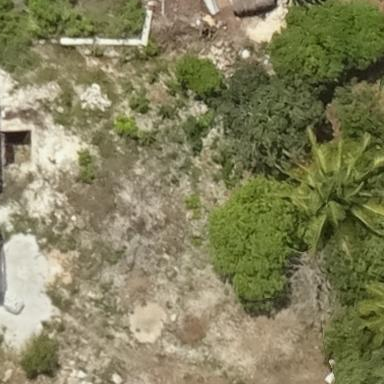

In [289]:
filename = np.random.choice(os.listdir(image_path)) ; print(filename)
im = Image.open(os.path.join(image_path, filename)) ; im

### Prediction

In [290]:
prediction = model.detect(np.expand_dims(np.array(im), 0))

In [291]:
p = prediction[0]
p["rois"], p["class_ids"], p["scores"]

(array([[  0,  21,  51, 155],
        [216,   0, 359,  46]], dtype=int32),
 array([3, 1], dtype=int32),
 array([0.78267264, 0.78256774], dtype=float32))

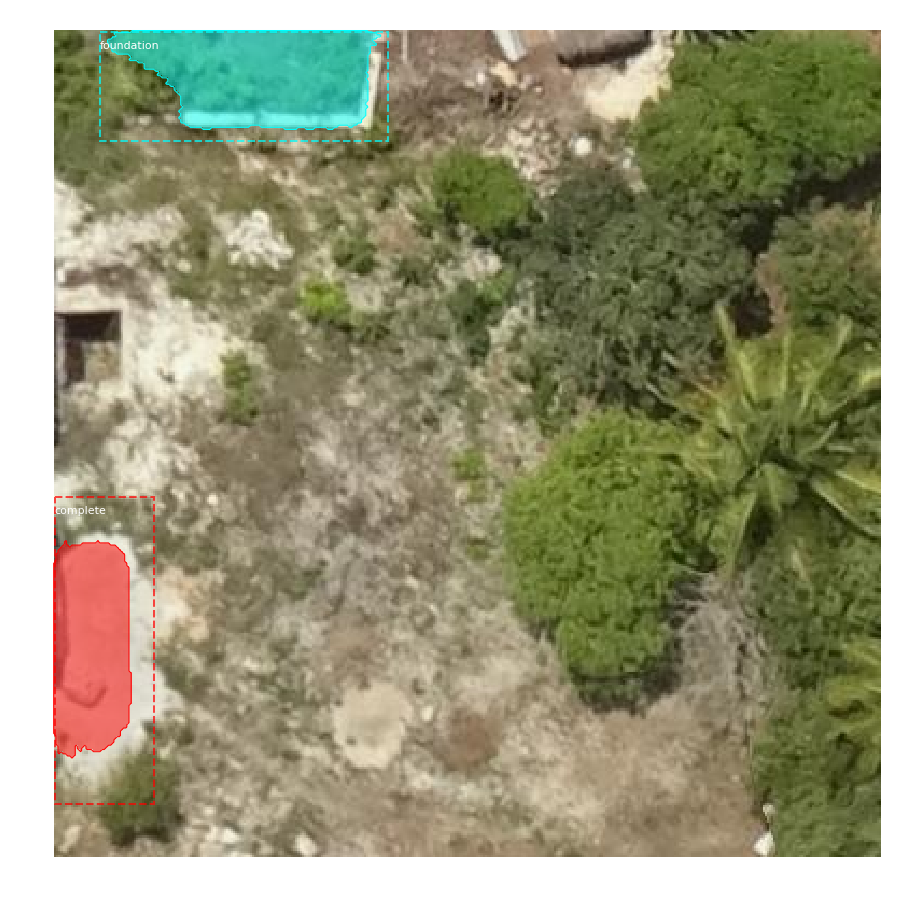

In [292]:
visualize.display_instances(np.array(im),
                            p["rois"],
                            p["masks"],
                            p["class_ids"],
                            ["", "complete", "incomplete", "foundation"],
                           show_mask=True)

## Draft

In [49]:
with open("../data/open_ai_tanzania/preprocessed/384/testing/prediction_log.json") as fobj:
    prediction_log = json.load(fobj)

FileNotFoundError: [Errno 2] No such file or directory: '../data/open_ai_tanzania/preprocessed/384/testing/prediction_log.json'

In [ ]:
for filename in os.listdir("../data/open_ai_tanzania/input/testing/images"):
    print(sum([pl for key, pl in prediction_log.items() if filename in key]))

In [34]:
os.listdir("../data/open_ai_tanzania/input/testing/images")

['5ae242fd0b093000130afd33.tif',
 '5ae318220b093000130afd99.tif',
 '5ae36dd70b093000130afdbb.tif',
 '5ae38a540b093000130afed0.tif',
 '5ae38a540b093000130aff24.tif',
 '5b00370f2b6a08001185f129.tif',
 '5b00370f2b6a08001185f12b.tif']

5ae38a540b093000130aff24_384_384_8832_34944.json


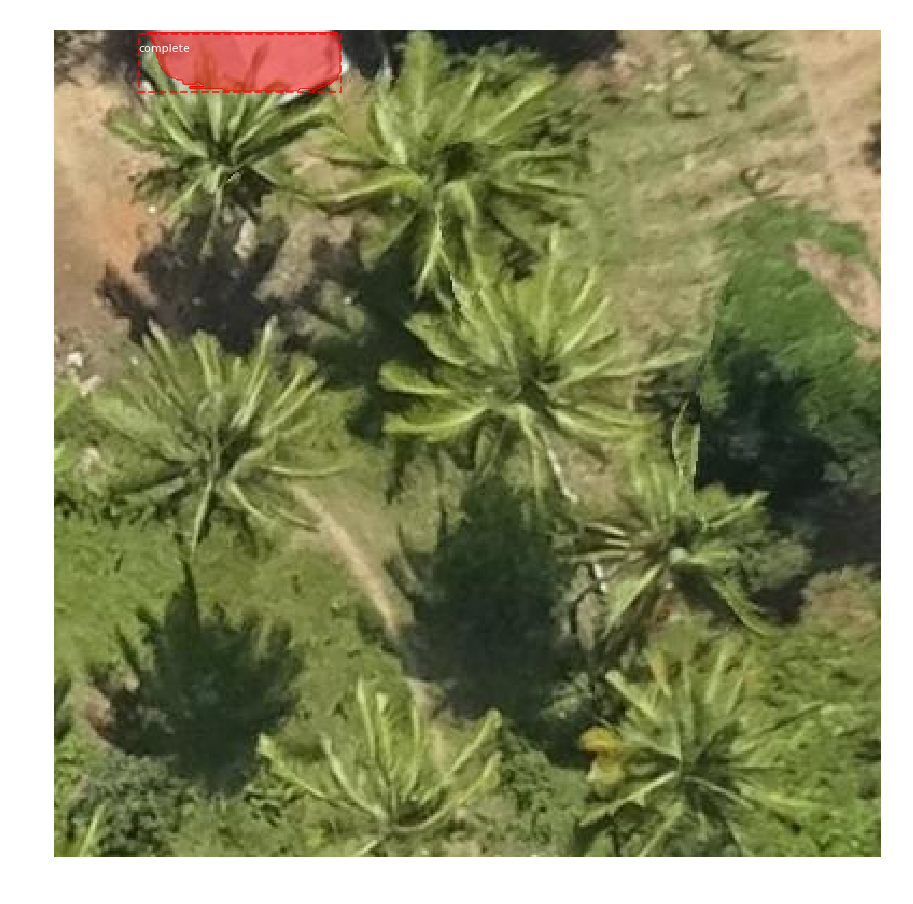

5ae242fd0b093000130afd33_384_384_25344_13824.json


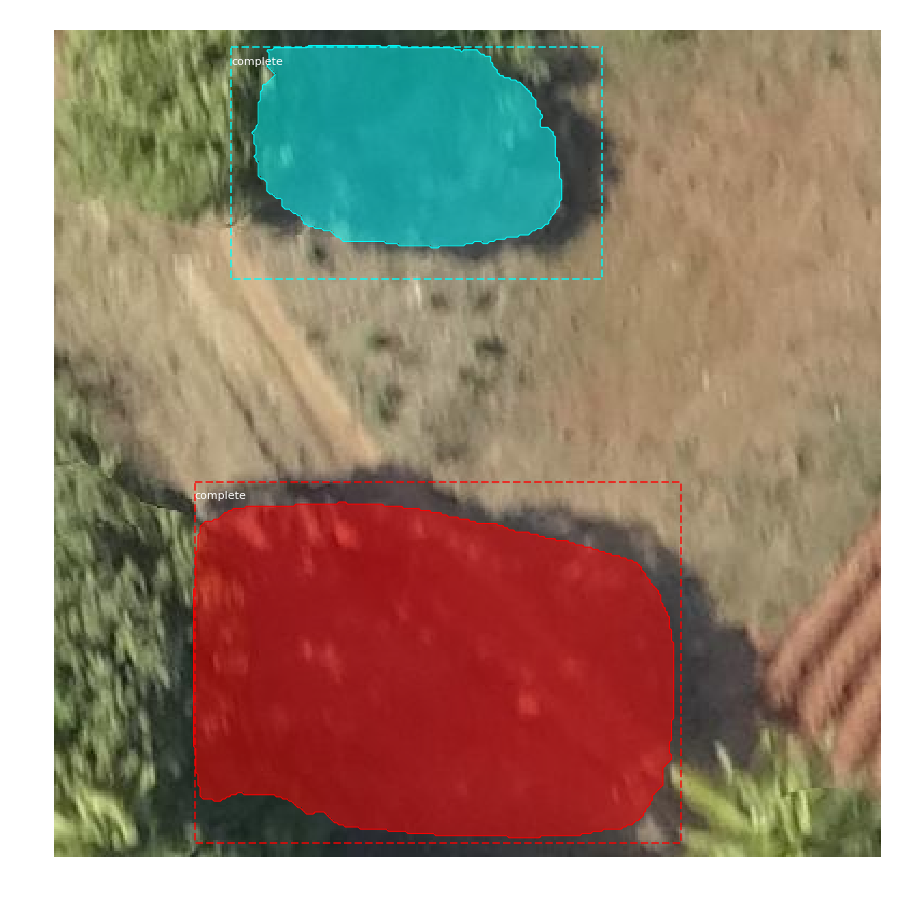

5ae242fd0b093000130afd33_384_384_25344_14208.json


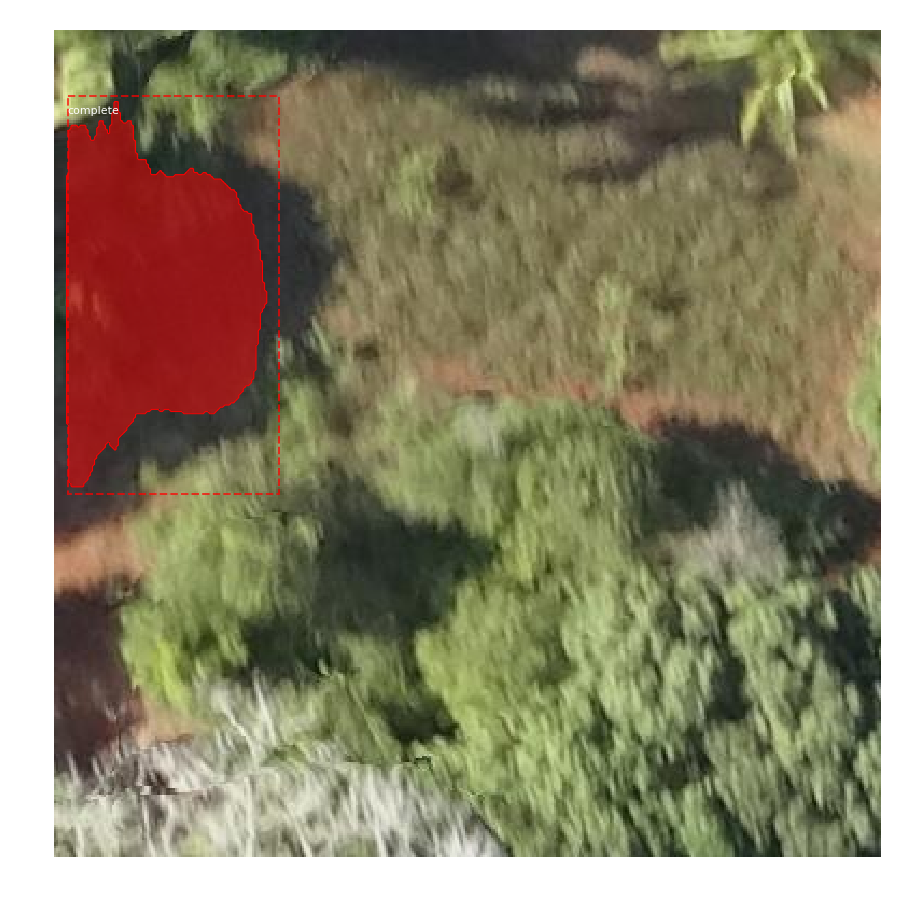

5ae242fd0b093000130afd33_384_384_25344_14592.json


In [ ]:
filenames = os.listdir("../data/open_ai_tanzania/preprocessed/384/testing/predicted_labels/")
for f in filenames[:100]:
    with open("../data/open_ai_tanzania/preprocessed/384/testing/predicted_labels/"+f) as fobj:
        p = json.load(fobj)
    if len(p["class_ids"]) > 0:
        print(f)
        im = np.array(Image.open(os.path.join("../data/open_ai_tanzania/preprocessed/384/testing/images", f.replace(".json", ".tif"))))
        prediction = model.detect(np.expand_dims(im, 0))
        visualize.display_instances(np.array(im),
                                    prediction[0]["rois"],
                                    prediction[0]["masks"],
                                    prediction[0]["class_ids"],
                                    ["", "complete", "incomplete", "foundation"],
                                    show_mask=True)